In [1]:
import gc
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import math

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import models
from tensorflow.keras import layers

print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU')) 

# CLEAN UP MEMORY
gc.collect()

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


22

In [2]:
#READ DATA FROM FILE
dataset=pd.read_csv("C:/ProgramData/ETH/TrainingData/training.csv", sep=',',header=0)
#PRINT DATA
print(dataset)

             close        date         high          low         open  \
0       738.615957  1609459200   738.615957   736.212707   736.212707   
1       733.205047  1609459500   736.074300   733.205047   736.074300   
2       730.580620  1609459800   733.400000   730.298975   733.195132   
3       731.879341  1609460100   731.917669   731.282995   731.282995   
4       731.563416  1609460400   731.563416   729.518833   731.371327   
...            ...         ...          ...          ...          ...   
28552  2070.659658  1618008000  2072.468643  2069.256053  2071.227033   
28553  2068.199985  1618008300  2071.931117  2067.387556  2071.849323   
28554  2067.308124  1618008600  2068.226492  2066.900000  2068.100000   
28555  2066.607410  1618008900  2068.397512  2063.776302  2067.365079   
28556  2064.081855  1618009200  2066.334865  2062.151488  2064.600000   

       quoteVolume        volume  weightedAverage  
0         9.191832   6776.937020       737.278171  
1        75.298761 

In [3]:
#CONDUCT PEARSON CORRELATION
correlation_matrix = dataset.corr()
print(correlation_matrix)

                    close      date      high       low      open  \
close            1.000000  0.842761  0.999924  0.999915  0.999842   
date             0.842761  1.000000  0.842318  0.843281  0.842728   
high             0.999924  0.842318  1.000000  0.999866  0.999926   
low              0.999915  0.843281  0.999866  1.000000  0.999903   
open             0.999842  0.842728  0.999926  0.999903  1.000000   
quoteVolume     -0.291874 -0.326376 -0.287332 -0.297154 -0.291147   
volume          -0.139163 -0.210136 -0.134564 -0.144509 -0.138462   
weightedAverage  0.999952  0.842804  0.999959  0.999961  0.999930   

                 quoteVolume    volume  weightedAverage  
close              -0.291874 -0.139163         0.999952  
date               -0.326376 -0.210136         0.842804  
high               -0.287332 -0.134564         0.999959  
low                -0.297154 -0.144509         0.999961  
open               -0.291147 -0.138462         0.999930  
quoteVolume         1.000000  

<AxesSubplot:>

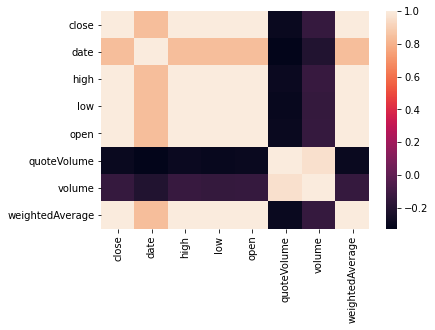

In [4]:
# plot the heatmap
sns.heatmap(correlation_matrix, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)

In [5]:
#SELECT FEATURES AND TARGET
data = dataset[["high","low","open","weightedAverage", "close"]]
print(data)

              high          low         open  weightedAverage        close
0       738.615957   736.212707   736.212707       737.278171   738.615957
1       736.074300   733.205047   736.074300       734.614140   733.205047
2       733.400000   730.298975   733.195132       731.815460   730.580620
3       731.917669   731.282995   731.282995       731.620666   731.879341
4       731.563416   729.518833   731.371327       730.260155   731.563416
...            ...          ...          ...              ...          ...
28552  2072.468643  2069.256053  2071.227033      2070.678585  2070.659658
28553  2071.931117  2067.387556  2071.849323      2070.791303  2068.199985
28554  2068.226492  2066.900000  2068.100000      2067.342576  2067.308124
28555  2068.397512  2063.776302  2067.365079      2064.862044  2066.607410
28556  2066.334865  2062.151488  2064.600000      2063.824462  2064.081855

[28557 rows x 5 columns]


In [6]:
#SCALE DATA 
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [7]:
#DEFINE MODEL CREATION METHOD. ENABLES EASY HYPER PARAM TUNING
def build_model(inputs, neurons, activ_func, dropout, loss, optimizer):
    """
    inputs: input data as numpy array
    output_size: number of predictions per input sample
    neurons: number of neurons/ units in the LSTM layer
    active_func: Activation function to be used in LSTM layers and Dense layer
    dropout: dropout ration, default is 0.25
    loss: loss function for calculating the gradient
    optimizer: type of optimizer to backpropagate the gradient
    
    This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer 
    and finally a dense layer to produce the output using keras' sequential model.
    Return: Keras sequential model and model summary
    """
    
    model = models.Sequential()
    model.add(layers.LSTM(neurons, return_sequences=False, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(units=inputs.shape[2]))
    #model.add(layers.Dense(units=1))
    model.add(layers.Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    model.summary()
    return model

In [8]:
def split_data(training_split, data):
    # split into train and test sets
    train_size = int(len(data) * training_split)
    test_size = len(data) - train_size
    train, test = data[0:train_size,:], data[train_size:len(data),:]
    return (train, test)

In [9]:
def split_sequences_multivariate_output(sequences, look_back, look_forward):
    x, y = list(), list()
    for i in range(len(sequences)):
        # end index of lookback window
        lookback_end_index = i + look_back
        lookforward_end_index = i + look_back + look_forward
        # exit if we are beyond the dataset
        if lookforward_end_index > len(sequences)-1:
            break
        # gather input and output parts of the pattern. input is lookback window of data, output is next step of data
        seq_x, seq_y = sequences[i:lookback_end_index, :], sequences[lookback_end_index:lookforward_end_index, :]
        x.append(seq_x)
        y.append(seq_y)
            
    return np.array(x), np.array(y)

In [11]:
#INIT HYPER PARAMS
neurons = 512
activation_function = 'tanh'
loss = 'mse'
optimizer="adam"
dropout = 0.2
batch_size = 25
epochs = 125
#epochs = 1
training_split = 1
look_back = 12
look_forward = 1
random_seed = 202

In [12]:
#SPLIT DATA FOR TRAINING
train_data, test_data = split_data(training_split, data)

In [13]:
#SHAPE DATA FOR LSTM INPUT
x_train, y_train = split_sequences_multivariate_output(train_data, look_back, look_forward)
x_test, y_test = split_sequences_multivariate_output(test_data, look_back, look_forward)

#PRINT DATA SHAPE
print('training features shape == {}.'.format(x_train.shape))
print('training targets shape == {}.'.format(y_train.shape))
print('testing features shape == {}.'.format(x_test.shape))
print('testing features shape == {}.'.format(y_test.shape))

print("X_TRAIN")
print(x_train)
print("Y_TRAIN")
print(y_train)

training features shape == (28544, 12, 5).
training targets shape == (28544, 1, 5).
testing features shape == (0,).
testing features shape == (0,).
X_TRAIN
[[[0.01353806 0.01488267 0.01387366 0.01399334 0.01554984]
  [0.01176073 0.01277252 0.01377683 0.01213145 0.01176352]
  [0.00989065 0.01073364 0.0117626  0.01017546 0.00992706]
  ...
  [0.01040548 0.01224024 0.01162609 0.01147227 0.01228803]
  [0.01086964 0.01334798 0.01234335 0.01198792 0.01265165]
  [0.01130775 0.01330036 0.01232564 0.01219856 0.01228999]]

 [[0.01176073 0.01277252 0.01377683 0.01213145 0.01176352]
  [0.00989065 0.01073364 0.0117626  0.01017546 0.00992706]
  [0.00885408 0.01142402 0.01042489 0.01003932 0.01083584]
  ...
  [0.01086964 0.01334798 0.01234335 0.01198792 0.01265165]
  [0.01130775 0.01330036 0.01232564 0.01219856 0.01228999]
  [0.01135231 0.01310419 0.01272452 0.01181475 0.01329945]]

 [[0.00989065 0.01073364 0.0117626  0.01017546 0.00992706]
  [0.00885408 0.01142402 0.01042489 0.01003932 0.01083584]
  

In [14]:
#ONLY NEEDS TO HAPPEN IF LOOK FORWARD IS 1
#y_train =  np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1]))
#y_test =  np.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1]))

In [15]:
#PRINT DATA SHAPE
print('training features shape == {}.'.format(x_train.shape))
print('training targets shape == {}.'.format(y_train.shape))
print('testing features shape == {}.'.format(x_test.shape))
print('testing features shape == {}.'.format(y_test.shape))

print("X_TRAIN")
print(x_train)
print("Y_TRAIN")
print(y_train)

training features shape == (28544, 12, 5).
training targets shape == (28544, 1, 5).
testing features shape == (0,).
testing features shape == (0,).
X_TRAIN
[[[0.01353806 0.01488267 0.01387366 0.01399334 0.01554984]
  [0.01176073 0.01277252 0.01377683 0.01213145 0.01176352]
  [0.00989065 0.01073364 0.0117626  0.01017546 0.00992706]
  ...
  [0.01040548 0.01224024 0.01162609 0.01147227 0.01228803]
  [0.01086964 0.01334798 0.01234335 0.01198792 0.01265165]
  [0.01130775 0.01330036 0.01232564 0.01219856 0.01228999]]

 [[0.01176073 0.01277252 0.01377683 0.01213145 0.01176352]
  [0.00989065 0.01073364 0.0117626  0.01017546 0.00992706]
  [0.00885408 0.01142402 0.01042489 0.01003932 0.01083584]
  ...
  [0.01086964 0.01334798 0.01234335 0.01198792 0.01265165]
  [0.01130775 0.01330036 0.01232564 0.01219856 0.01228999]
  [0.01135231 0.01310419 0.01272452 0.01181475 0.01329945]]

 [[0.00989065 0.01073364 0.0117626  0.01017546 0.00992706]
  [0.00885408 0.01142402 0.01042489 0.01003932 0.01083584]
  

In [16]:
# CLEAN UP MEMORY
gc.collect()
# random seed for reproducibility
np.random.seed(random_seed)
# initialise model architecture
model = build_model(x_train, neurons=neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer)
# train model on data
#history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test), shuffle=False)
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               1060864   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 2565      
_________________________________________________________________
activation (Activation)      (None, 5)                 0         
Total params: 1,063,429
Trainable params: 1,063,429
Non-trainable params: 0
_________________________________________________________________
Epoch 1/125
1142/1142 [==============================] - 8s 5ms/step - loss: 6.5834e-04 - mae: 0.0195
Epoch 2/125
1142/1142 [==============================] - 5s 4ms/step - loss: 0.0087 - mae: 0.0378
Epoch 3/125
1142/1142 [=====================

1142/1142 [==============================] - 5s 4ms/step - loss: 2.6896e-04 - mae: 0.0114
Epoch 73/125
1142/1142 [==============================] - 5s 4ms/step - loss: 2.8624e-04 - mae: 0.0117
Epoch 74/125
1142/1142 [==============================] - 5s 4ms/step - loss: 2.7289e-04 - mae: 0.0114
Epoch 75/125
1142/1142 [==============================] - 5s 5ms/step - loss: 2.7482e-04 - mae: 0.0115
Epoch 76/125
1142/1142 [==============================] - 5s 4ms/step - loss: 2.7325e-04 - mae: 0.0114
Epoch 77/125
1142/1142 [==============================] - 5s 5ms/step - loss: 2.7851e-04 - mae: 0.0116A: 2s - loss: 3.4804e-04 - ETA: 1
Epoch 78/125
1142/1142 [==============================] - 5s 4ms/step - loss: 2.8574e-04 - mae: 0.0116
Epoch 79/125
1142/1142 [==============================] - 5s 4ms/step - loss: 2.5134e-04 - mae: 0.0111
Epoch 80/125
1142/1142 [==============================] - 5s 4ms/step - loss: 2.5532e-04 - mae: 0.0112
Epoch 81/125
1142/1142 [=============================

KeyError: 'val_loss'

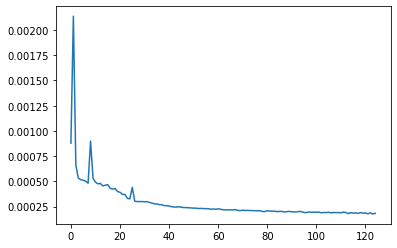

In [17]:
#PLOT LOSS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

KeyError: 'val_mae'

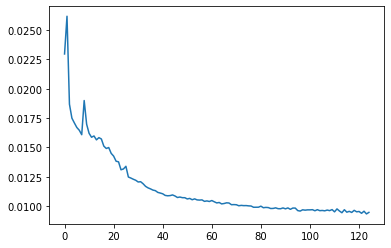

In [18]:
#PLOT LOSS
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
#PERFORM PREDICTIONS
train_predict = model.predict(x_train)
print(train_predict.shape)

(28544, 5)


In [ ]:
test_predict = model.predict(x_test)
print(test_predict.shape)

In [20]:
train_predict_shaped = scaler.inverse_transform(np.array(train_predict))
train_predict_shaped = train_predict_shaped[:,4:5]
print(train_predict_shaped.shape)

(28544, 1)


In [ ]:
test_predict_shaped = scaler.inverse_transform(np.array(test_predict))
test_predict_shaped = test_predict_shaped[:,4:5]
print(test_predict_shaped.shape)

In [21]:
train_mse = mean_squared_error(y_train[:,0,4], train_predict[:,4])
# calculate mean squared error
print('Train Score: %.2f RMSE' % (train_mse))
# calculate root mean squared error
print('Train Score: %.2f RMSE' % (math.sqrt(train_mse)))
# calculate root mean abs error
print('Train Score: %.2f MAE' % (mean_absolute_error(y_train[:,0,4], train_predict[:,4])))
# calculate root mean squared error
print('Train Score: %.2f MAPE' % (mean_absolute_percentage_error(y_train[:,0,4], train_predict[:,4])))

Train Score: 0.00 RMSE
Train Score: 0.06 RMSE
Train Score: 0.06 MAE
Train Score: 4975822269.59 MAPE


In [ ]:
test_mse = mean_squared_error(y_test[:,0,4], test_predict[:,4])
print('Test Score: %.2f RMSE' % (test_mse))
print('Test Score: %.2f RMSE' % (math.sqrt(test_mse)))
print('Test Score: %.2f MAE' % (mean_absolute_error(y_test[:,0,4], test_predict[:,4])))
print('Test Score: %.2f MAPE' % (mean_absolute_percentage_error(y_test[:,0,4], test_predict[:,4])))

In [22]:

baseData = scaler.inverse_transform(data)[:, 4:5]
# initialize to length of base data
trainPredictPlot = np.empty_like(baseData)
# set all elements to nan
trainPredictPlot[:, :] = np.nan
# shift train predictions by window length for plotting
trainPredictPlot[look_back:len(train_predict_shaped)+look_back, :] = train_predict_shaped

In [23]:
# initialize to length of base data
testPredictPlot = np.empty_like(baseData)
#set all elements to nan
testPredictPlot[:, :] = np.nan
#shift by length of training predictions plus 
testPredictPlot[len(train_predict_shaped)+(look_back*2)+1:len(baseData)-1, :] = test_predict_shaped[0:12901, :]

NameError: name 'test_predict_shaped' is not defined

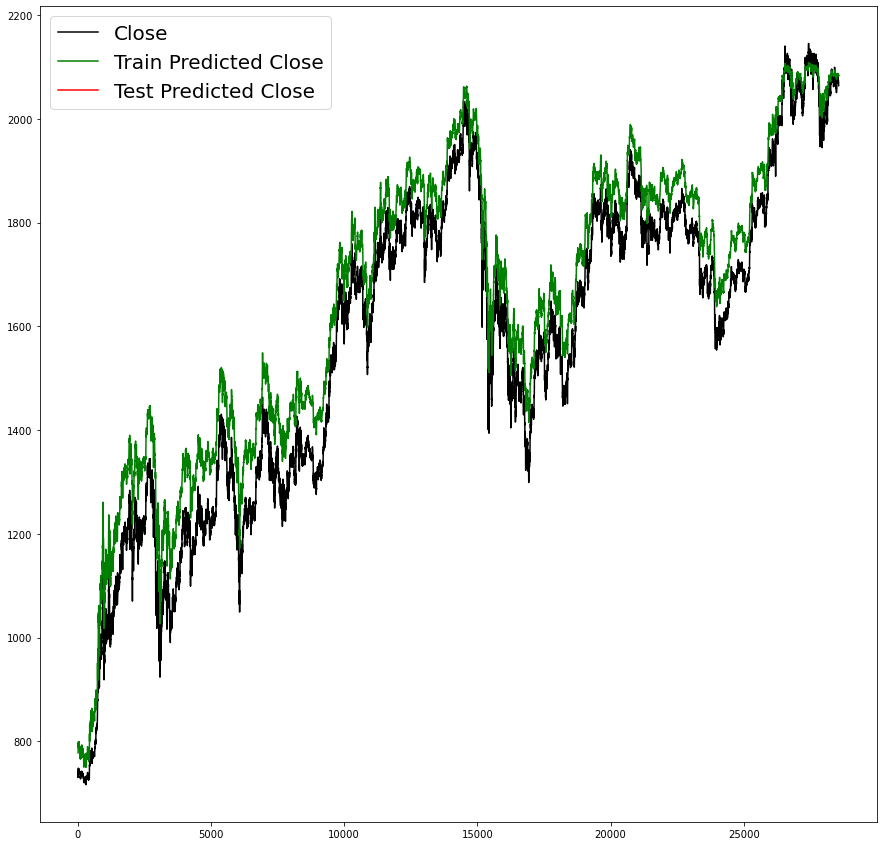

In [24]:
# plot baseline and predictions
plt.figure(figsize=(15,15))
plt.plot(baseData, '-', color='k', label='Close')
plt.plot(trainPredictPlot, '-', color='g', label='Train Predicted Close')
plt.plot(testPredictPlot, '-', color='r', label='Test Predicted Close')
plt.legend(fontsize=20)

In [ ]:
baseTestData = scaler.inverse_transform(test_data)[:, 4:5]
testPredictPlot2 = np.empty_like(baseTestData)
testPredictPlot2[:, :] = np.nan
testPredictPlot2[look_back:len(train_predict_shaped)+look_back, :] = test_predict_shaped
# plot baseline and predictions
plt.figure(figsize=(15,15))
plt.plot(baseTestData, '-', color='k', label='Close')
plt.plot(testPredictPlot2, '-', color='r', label='Test Predicted Close')
plt.legend(fontsize=20)

plt.show()

In [25]:
from datetime import datetime
import os

#CREATE OUTPUT DIRECTORY
ts = datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
output_dir = os.path.join("C:/ProgramData/ETH/Model/", ts)

os.mkdir(output_dir)

model_json = model.to_json()
#WRITE OUT MODEL
with open(os.path.join(output_dir, "model.json"), "w") as json_file:
    json_file.write(model_json)
    
hyper_params = "NEURONS: " + str(neurons) + "\r\n"
hyper_params + "ACTIVATION_FUNC: " + str(activation_function) + "\r\n"
hyper_params + "LOSS: " + str(loss) + "\r\n"
hyper_params + "OPTIMIZER: " + str(optimizer) + "\r\n"
hyper_params + "DROPOUT: " + str(dropout) + "\r\n"
hyper_params + "BATCH_SIZE: " + str(batch_size) + "\r\n"
hyper_params + "EPOCHS: " + str(epochs) + "\r\n"
hyper_params + "TRAINING_SPLIT: " + str(training_split) + "\r\n"
hyper_params + "LOOK_BACK: " + str(look_back) + "\r\n"
hyper_params + "LOOK_FORWARD: " + str(look_forward) + "\r\n"
hyper_params + "RANDOM_SEED: " + str(random_seed) + "\r\n"
    
with open(os.path.join(output_dir, "hyper_params.txt"), "w") as param_file:
    param_file.write(hyper_params)

model.save_weights(os.path.join(output_dir, "weights.h5"))